# DSCI 310 Group 11 Project: Predicting Probability of Wicket on a Delivery in Cricket

Alex Lin

Jackson Siemens

Shruti Vijaykumar Seetharam

Hanlin Zhao

## Abstract

Our project aims to predict the probability of a wicket on a delivery in Cricket. We are going to look at ball-by-ball factors that could potentially affect this probability and see how the wicket probability changes with game conditions. Forecasting methods for cricket use complex regression models as discussed by Asif & McHale (2016), which is why we decided against predicting win probability, a common prediction model used for sports


## Introduction

Cricket is a bat and ball sport involving two teams of eleven players each. Originating in the 16th century, Cricket today is commonly played in three formats: Tests, One Day Internationals and T20 Internationals. Our analysis will be specifically focusing on T20 International games and looking at the conditions of those games to analyze our prediction probability. In a T20 game, one team will bat first and set a target number of runs in 20 overs or until 10 wickets are lost. The other team will bat second, and to win the game, they must exceed the target set by the second team in 20 overs or less. Each of the 11 players in the team will need to bat as more wickets are lost, but some bat more often than others, given all wickets are not always lost. Only some players are bowlers. There are multiple different ways of getting a wicket, and these can be affected by the following factors:

1. Bowler: The skill of a bowler can affect the probability
2. Batter: Similarly, the skill of a batter can affect the probability
3. Inning: Determines which team is batting and bowling
4. Over: An over consists of 6 deliveries thrown by the bowler from one end of the pitch to the batter on the other end. The over can determine how much risk a batter is willing to take with his next ball.
5. Ball in the over: The specific delivery in the over. Batters are more likely to take risks towards the end of an over compared to the beginning.
6. Runs scored till now: Looks at the amount of runs scored in the inning up until the current ball. Fewer runs scored may mean the batter is more likely to take risks in order to get more.
7. Powerplay: A powerplay is when there are fielding restrictions placed on the bowling team, making it harder for them to get a wicket. 

We will be looking at the above factors along with some others to judge what factors may be best for our model in the Exploratory Data Analysis section. We will be reading our data in json files from the [Cricsheet](https://cricsheet.org/downloads/) website, and converting it to our desired `csv` format using the scripts in the `cricsheet_json_parsing.ipynb` file which can be found in the `src` folder. 

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('jupyterlab')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Methods

Firstly, we will perform some exploratory data analysis on the training data to get a better understanding of the dataset and what relationships there are with our target variable.

### Exploratory Data Analysis

In [2]:
data = pd.read_csv("data/cricket_test.csv")
data = data.drop(columns = ["Unnamed: 0"])
data.head().style.set_caption("Table 1: Overview of full dataset").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,game_id,season,team,over,batter,batter_id,bowler,bowler_id,non_striker,non_striker_id,wides,noballs,legbyes,byes,wicket,player_out,player_out_id,fielders_name,fielders_id,wicket_type,runs_batter,runs_extras,runs_total,team_over,over_ball,inning,runs_cumulative,powerplay
0,1001349,2016/17,Australia,0,AJ Finch,b8d490fd,SL Malinga,a12e1d51,M Klinger,b970a03f,0,0,0,0,0,nan,nan,nan,nan,nan,0,0,0,Australia_0,1,1,0,1
1,1001349,2016/17,Australia,0,AJ Finch,b8d490fd,SL Malinga,a12e1d51,M Klinger,b970a03f,0,0,0,0,0,nan,nan,nan,nan,nan,0,0,0,Australia_0,2,1,0,1
2,1001349,2016/17,Australia,0,AJ Finch,b8d490fd,SL Malinga,a12e1d51,M Klinger,b970a03f,0,0,0,0,0,nan,nan,nan,nan,nan,1,0,1,Australia_0,3,1,1,1
3,1001349,2016/17,Australia,0,M Klinger,b970a03f,SL Malinga,a12e1d51,AJ Finch,b8d490fd,0,0,0,0,0,nan,nan,nan,nan,nan,2,0,2,Australia_0,4,1,3,1
4,1001349,2016/17,Australia,0,M Klinger,b970a03f,SL Malinga,a12e1d51,AJ Finch,b8d490fd,0,0,0,0,0,nan,nan,nan,nan,nan,0,0,0,Australia_0,5,1,3,1


In [3]:
X = data.drop(columns = ['wicket'])
y = data['wicket']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
train_data = pd.concat([X_train, y_train], axis = 1)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510652 entries, 438303 to 277869
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   game_id          510652 non-null  int64 
 1   season           510652 non-null  object
 2   team             510652 non-null  object
 3   over             510652 non-null  int64 
 4   batter           510652 non-null  object
 5   batter_id        510652 non-null  object
 6   bowler           510652 non-null  object
 7   bowler_id        510652 non-null  object
 8   non_striker      510652 non-null  object
 9   non_striker_id   510652 non-null  object
 10  wides            510652 non-null  int64 
 11  noballs          510652 non-null  int64 
 12  legbyes          510652 non-null  int64 
 13  byes             510652 non-null  int64 
 14  player_out       28104 non-null   object
 15  player_out_id    28104 non-null   object
 16  fielders_name    17956 non-null   object
 17  fielders_i

In [5]:
train_data.describe().style.set_caption("Table 2: Summary of Numeric Variables").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,game_id,over,wides,noballs,legbyes,byes,runs_batter,runs_extras,runs_total,over_ball,inning,runs_cumulative,powerplay,wicket
count,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000,510652.000000
mean,1145703.858967,8.885989,0.047739,0.005152,0.016728,0.007463,1.038470,0.077170,1.115640,3.660452,1.463500,63.071401,0.331427,0.055036
std,296516.161221,5.633009,0.278095,0.073962,0.168515,0.139016,1.461122,0.358287,1.454276,1.856491,0.498666,44.643770,0.470727,0.228050
min,211028.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1130746.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,26.000000,0.000000,0.000000
50%,1272373.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000,1.000000,57.000000,0.000000,0.000000
75%,1336082.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,5.000000,2.000000,92.000000,1.000000,0.000000
max,1422802.000000,19.000000,5.000000,5.000000,5.000000,5.000000,7.000000,6.000000,7.000000,19.000000,2.000000,333.000000,1.000000,1.000000


The dataset contains 28 columns and 510652 observations related to cricket. The ratio of quantitative to categorical (ordinal and nominal) data is approximately 50:50. Note that the columns **player_out, player_out_id, fielder_name, fielders_id, and wicket_type** show a significant amount of missing values. Player_out and player_out_id may be missing due to inapplicability (e.g., no one is out), which results in fielder_name, fielder_id, and wicket_type being invalid in these observations. Thus, these missing data are likely classified as **missing at random(MAR)**. Given the complexity of imputing these values, they are unlikely to be included in our further analysis.

Note that, among the 28 columns, there were few attributes generated based on existing columns, and they are "over_ball", "inning", "runs_cumulative", and "powerplay". Although they are all integers, it is important to note that, only "overball" and "runs_cumulative" are quantitative, whereas "inning" and "powerplay" are categorical. Detailed calculations of these attributes are in the `cricsheet-json-parsing.ipynb` file. 

In [6]:
def vis_bar(x_input, width, height):
    return alt.Chart(train_data).mark_bar().encode(
        x = x_input,
        y = "count()"
    ).properties(
        width = width, 
        height = height
    )

over = vis_bar("over", 150, 150)
wides = vis_bar("wides", 150, 150)
noballs = vis_bar("noballs", 150, 150)
legbyes = vis_bar("legbyes", 150, 150)
byes = vis_bar("byes", 150, 150)
wicket = vis_bar("wicket", 150, 150)
run_batter = vis_bar("runs_batter", 150, 150)
run_extras = vis_bar("runs_extras", 150, 150)
run_total = vis_bar("runs_total", 150, 150)
over_ball = vis_bar("over_ball", 150, 150)
runs_cumulative = vis_bar("runs_cumulative", 150, 150)

title_1_a = alt.Chart(
    {"values": [{"text": "Figure 1.1: Distribution of Variables"}]}
).mark_text(size=20).encode(
    text="text:N"
)

v1 = alt.hconcat(over, wides, noballs)
v2 = alt.hconcat(legbyes, byes, wicket)
v3 = alt.hconcat(run_batter, run_extras, run_total)
v4 = alt.hconcat(over_ball, runs_cumulative)
chart1 = alt.vconcat(title_1_a, v1, v2, v3, v4)
chart1.save('images/chart1.png')

![Figure 1.1](images/chart1.png)

In [7]:
season = vis_bar("season", 500, 150)
team = vis_bar("team", 900, 150)
inning = vis_bar("inning:N", 150, 150)
powerplay = vis_bar("powerplay:N", 150, 150)

title_1_b = alt.Chart(
    {"values": [{"text": "Figure 1.2: Distribution of Variables"}]}
).mark_text(size=20).encode(
    text="text:N"
)

h_1 = alt.hconcat(inning, powerplay)
chart2 = alt.vconcat(title_1_b, season, team, h_1)
chart2.save('images/chart2.png')

![Figure 1.2](images/chart2.png)

Figure 1.1 and Figure 1.2 look at the distribution of our variables.

In [8]:
pd.concat([train_data["batter"].value_counts().reset_index().head(5), 
           train_data["batter"].value_counts().reset_index().tail(5)]).style.set_caption(
    "Table 3.1: Batter Summary Count").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,batter,count
0,V Kohli,2115
1,Babar Azam,2073
2,RG Sharma,2033
3,MJ Guptill,1894
4,Bismah Maroof,1735
4694,K Cawte,1
4695,M Stoman,1
4696,B Biza,1
4697,JJ Celestine,1
4698,AS Dean,1


In [9]:
pd.concat([train_data["bowler"].value_counts().reset_index().head(5), 
           train_data["bowler"].value_counts().reset_index().tail(5)]).style.set_caption(
    "Table 3.2: Bowler Summary Count").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,bowler,count
0,TG Southee,1990
1,Shakib Al Hasan,1747
2,IS Sodhi,1630
3,AU Rashid,1556
4,MJ Santner,1537
3474,AV Lazarus,1
3475,J Grzinic,1
3476,Mahmudul Hasan Joy,1
3477,KH Prajapati,1
3478,Riyaz Kajalwala,1


In [10]:
pd.concat([train_data["non_striker"].value_counts().reset_index().head(5),
           train_data["non_striker"].value_counts().reset_index().tail(5)]).style.set_caption(
    "Table 3.3: Non-Striker Summary Count").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,non_striker,count
0,Babar Azam,2166
1,RG Sharma,1988
2,V Kohli,1978
3,BL Mooney,1901
4,Bismah Maroof,1789
4557,AS Dean,1
4558,Sumaiya Akter,1
4559,S Nunna,1
4560,JL Aras,1
4561,F Parkinson,1


Please note that the analysis excludes all columns related to "ID" as they are primarily for identification purposes and are unlikely to show significant patterns. It is observed that none of the quantitative attributes follow a normal distribution; most are right-skewed distributions. An interesting finding is noted in the attributes "over", where the frequency **steadily** decreases with increasing values, suggesting further analysis. Concerning ordinal attributes, we have a significantly higher amount of data from seasons that happened in recent years than in the past. Lastly, regarding nominal attributes, we are seeing an uneven distribution appearance of players(batter, bowler, and non-striker) in this dataset, by using non-striker as an example, some players such as V Kohli appear around 2100 times in this dataset, where other players such as F Bangur only appeared once.  Due to such a large number of batters and bowlers in the dataset, we will not be using it in our analysis. To use these attributes, we will also need to create summary statistics for each batters and bowlers, as explained by Dinsdale (2023) which is out of the scope of our project.

In terms of "team", there appear to be more teams from "New Zealand," "South Africa," "India," "West India," "Pakistan," "Bangladesh," "Sri Lanka"  "Australia," and "England" than teams from other countries/regions. The attribute"inning" doesn't seem to have a significant difference across the two conditions, however, for "powerplay," the number of occurrences in condition "0" is approximately twice as high as in condition "1."

In general, **none of the attributes in our dataset form a normal distribution**, with samples unevenly distributed across categorical attributes. It is important to remember this when training, testing, and interpreting the model, and to appropriately acknowledge this as a potential limitation. 

### Multivariate Analysis - Correlation Analysis

In [11]:
corr_data = train_data[["over", "wides", "noballs", "legbyes", "byes", "runs_batter", "runs_extras", "runs_total", "over_ball", "runs_cumulative", "wicket"]]
corr_df = corr_data.corr()
corr_df.style.set_caption("Table 4: Correlation Analysis").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,over,wides,noballs,legbyes,byes,runs_batter,runs_extras,runs_total,over_ball,runs_cumulative,wicket
over,1.000000,-0.019636,0.006787,-0.001467,0.015333,0.072301,-0.008488,0.070550,-0.019141,0.867475,0.070750
wides,-0.019636,1.000000,-0.011958,-0.017040,-0.009216,-0.122003,0.762080,0.065175,-0.000044,-0.012785,-0.038402
noballs,0.006787,-0.011958,1.000000,-0.003301,0.025591,0.005306,0.205879,0.056053,0.005681,0.015923,-0.015418
legbyes,-0.001467,-0.017040,-0.003301,1.000000,-0.005329,-0.070551,0.454336,0.041050,-0.002758,0.005618,-0.023344
byes,0.015333,-0.009216,0.025591,-0.005329,1.000000,-0.038156,0.383612,0.056175,0.003308,0.016791,-0.012153
runs_batter,0.072301,-0.122003,0.005306,-0.070551,-0.038156,1.000000,-0.141670,0.969805,-0.001714,0.166852,-0.165105
runs_extras,-0.008488,0.762080,0.205879,0.454336,0.383612,-0.141670,1.000000,0.104031,0.001171,0.002726,-0.048744
runs_total,0.070550,0.065175,0.056053,0.041050,0.056175,0.969805,0.104031,1.000000,-0.001434,0.168309,-0.177891
over_ball,-0.019141,-0.000044,0.005681,-0.002758,0.003308,-0.001714,0.001171,-0.001434,1.000000,0.038864,0.003144
runs_cumulative,0.867475,-0.012785,0.015923,0.005618,0.016791,0.166852,0.002726,0.168309,0.038864,1.000000,0.051161


In [12]:
corr_ = corr_df.stack()
corr_ = corr_.reset_index()
corr_.columns = ['row', 'column', 'corr']
corr_

chart3 = alt.Chart(corr_).mark_rect().encode(
    x = 'column',
    y = 'row',
    color = 'corr:Q',
    tooltip = 'corr:Q'
).properties(
    width = 400,
    height = 400,
    title = "Figure 2: Correlation Matrix"
)

chart3.save('images/chart3.png')

![Figure 3](images/chart3.png)

In [13]:
corr_table = corr_[corr_["row"] != corr_["column"]]
(corr_table.sort_values("corr", ascending = False).head(15)).style.set_caption("Table 5: Correlation Coefficients for top 15 most correlated variables").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,row,column,corr
62,runs_batter,runs_total,0.969805
82,runs_total,runs_batter,0.969805
9,over,runs_cumulative,0.867475
99,runs_cumulative,over,0.867475
17,wides,runs_extras,0.762080
67,runs_extras,wides,0.762080
69,runs_extras,legbyes,0.454336
39,legbyes,runs_extras,0.454336
50,byes,runs_extras,0.383612
70,runs_extras,byes,0.383612


Among the quantitative attributes, 5 pairs of relationship are above the threshold of weak correlation(**|r| > 0.3**), and they are: 

1. **batter_total & run_total(r = 0.97)**
2. **over & runs_cumulative(r = 0.87)**
3. **wides & runs_extras(r = 0.76)**
5. **legbyes & runs_extras(r = 0.46)**
8. **byes & runs_extra(r = 0.38)**

Note that, using Pearson's r might not be able to capture non-linear relationships that potentially exist among these relationships.

In [14]:
pd.DataFrame(train_data.groupby('powerplay')['wicket'].value_counts()).style.set_caption("Table 6: Wicket Count based off of Powerplay").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

We can see that there is a much higher proportion of wickets during the powerplay (approximately 31% are wickets compared to only around 6% in non-powerplay conditions). This could be attributed to players taking more risks since there are more fielding restrictions in the powerplay (Bhattacharjee et al., 2016, pp. 39 - 47) While most of the game is in the powerplay, and there is a class imbalance, this suggests that the powerplay does affect the chances of a wicket.

<Axes: title={'center': 'Figure 3.1 : Wicket count across overs'}, xlabel='Over', ylabel='Wicket Count'>

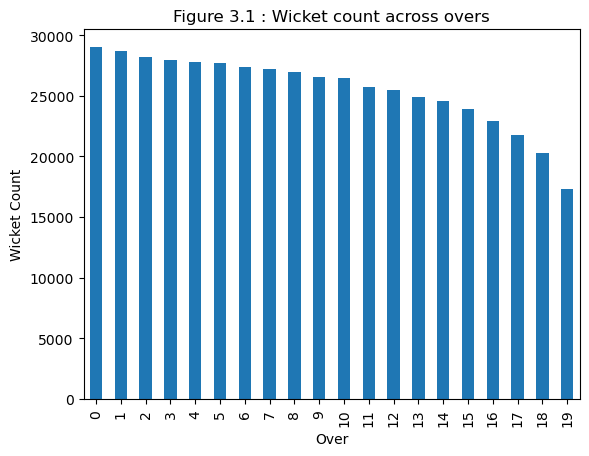

In [15]:
train_data.groupby('over')['wicket'].count().plot(kind = 'bar', xlabel="Over", ylabel="Wicket Count",
                                                   title = "Figure 3.1 : Wicket count across overs")

Similarly, the distribution above shows us that towards the end of the game, there are significantly less wickets than in the first few overs, which suggests that the variable "Over" could be used for our model as well.

<Axes: title={'center': 'Figure 3.2: Wicket count across innings'}, xlabel='inning', ylabel='Wicket Count'>

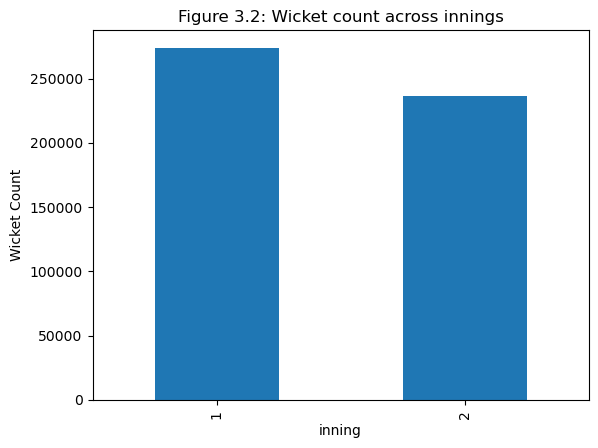

In [16]:
train_data.groupby('inning')['wicket'].count().plot(kind = 'bar', xlabel ='inning', ylabel = 'Wicket Count', 
                                                    title = "Figure 3.2: Wicket count across innings")

The above plot indicates that there are significantly more wickets in the first innings than the second. This could be attributed to the fact that in the second innings, batters are more likely to come in with a plan as they have a target in mind to chase and they are less likely to take risks. It is also possible that the number of wickets in the second innings is lower since the teams may not play the full second innings if they reach the target before that. So, this is a variable we will take into consideration when building our model.

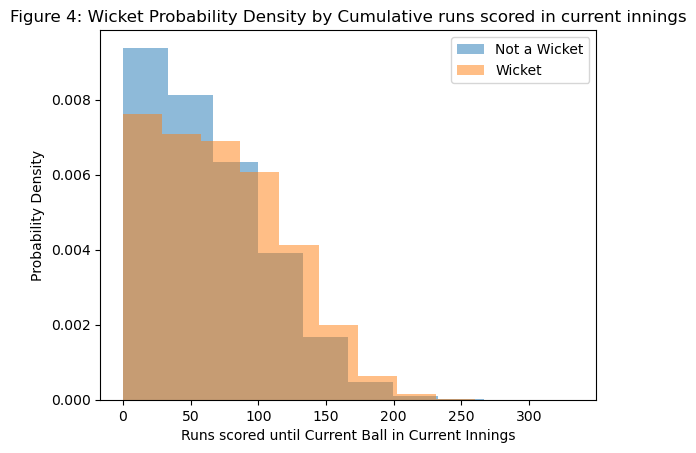

In [17]:
train_data_0 = train_data[train_data['wicket'] == 0]
train_data_1 = train_data[train_data['wicket'] == 1]

plt.hist(train_data_0['runs_cumulative'],  
         label="Not a Wicket",
         alpha = 0.5, 
         density = True) 
  
plt.hist(train_data_1['runs_cumulative'],  
         label="Wicket",
         alpha = 0.5,
         density=True) 
  
plt.legend(loc='upper right') 
plt.xlabel("Runs scored until Current Ball in Current Innings")
plt.ylabel("Probability Density")
plt.title('Figure 4: Wicket Probability Density by Cumulative runs scored in current innings') 
plt.show()

There does not seem to be too much of a relationship between the runs scored so far and whether there is a wicket or not, except when the runs are greater than 100. At this point, it is more likely to be a wicket.

### Model Building

Next, we will use the relationships we found above to build our model. The variables we will be looking at are `inning`, `over`, `powerplay`, `over_ball` and `runs_cumulative`. We will perform preprocessing on our datasets using one-hot encoding on our categorical variables. While there is only one numerical variable, we will still create a scaler in case we look to add other variables later in our analysis. 

We are going to create a Logistic Regression Model for this analysis. We decided against K-NN classification as there is class imbalance and even if we balance our classes by oversampling, our accuracy will decrease using a nearest neighbours methodology. We will be using a pipeline to fit our data.

In [18]:
ohe = OneHotEncoder(drop = "if_binary", handle_unknown="ignore")
scaler = StandardScaler()

model = LogisticRegression(C = 10, class_weight="balanced", n_jobs=-1)


numerical_feats = ['runs_cumulative']
categorical_feats = ['inning', 'over', 'powerplay', 'over_ball',]
drop_feats = ['game_id', 'season', 'team','batter', 'batter_id', 'bowler',
       'bowler_id', 'non_striker', 'non_striker_id', 'wides', 'noballs',
       'legbyes', 'byes', 'player_out', 'player_out_id', 'fielders_name',
       'fielders_id', 'wicket_type', 'runs_batter', 'runs_extras', 
       'runs_total', 'team_over']


ct = make_column_transformer(
    (scaler, numerical_feats), 
    (ohe, categorical_feats),
    ("drop", drop_feats)
)


In [19]:
pipe = make_pipeline(
    ct, 
    model
)

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['runs_cumulative']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['inning', 'over',
                                                   'powerplay', 'over_ball']),
                                                 ('drop', 'drop',
                                                  ['game_id', 'season', 'team',
                                                   'batter', 'batter_id',
                                                   'bowler', 'bowler_id',
                                                   'non_striker',
                                                   'non_striker_id', 'wides',
                                                   'noballs', 'legbyes', 'byes',
                                                   'player_out',
                                                   'player_out_id',
                                                   'fielders_name',
                                                   'fielders_id', 'wicket_type',
                                                   'runs_batter', 'runs_extras',
                                                   'runs_total',
                                                   'team_over'])])),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])

#### Hyperparameter Optimization

The hyperparameter we are looking at in Logistic Regression is $C$. We will be testing for 5 different values of $C$ and looking at which gives us ideal cross-validation and training scores.

In [21]:
C = [10 ** x for x in [0.5, 1, 2, 3, 4]]
train_score = []
cv_score = []
for c in C:
    model_new = LogisticRegression(C = c,  class_weight="balanced", n_jobs=-1)
    pipe_new = make_pipeline(ct, model_new)
    train_score.append(cross_validate(pipe_new, X_train, y_train, n_jobs =-1, return_train_score=True)['train_score'].mean())
    cv_score.append(cross_validate(pipe_new, X_train, y_train, n_jobs =-1, return_train_score=True)['test_score'].mean())

results = pd.DataFrame({"C": C, "Training Accuracy": train_score, "Cross Validation Accuracy": cv_score})

In [22]:
results.style.set_caption("Table 7: Cross Validation and Training Accuracy after Hyperparameter Optimization").set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,C,Training Accuracy,Cross Validation Accuracy
0,3.162278,0.703150,0.703179
1,10.000000,0.703024,0.702956
2,100.000000,0.702836,0.702888
3,1000.000000,0.703179,0.703129
4,10000.000000,0.703050,0.703015


We are choosing a $C$ of $\sqrt{10}$ as it overfits the least.

In [23]:
final_model = LogisticRegression(C = 10**0.5, class_weight="balanced", n_jobs=-1)

final_pipe = make_pipeline(
    ct,
    final_model
)

final_pipe.fit(X_train, y_train)

final_pipe.score(X_test, y_test)

0.7025099268452052

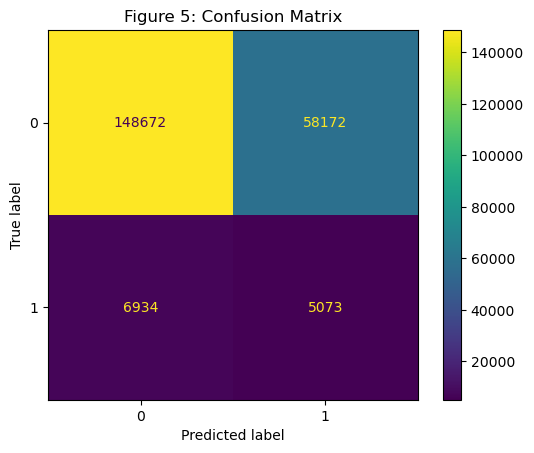

In [24]:
conf_mat = metrics.confusion_matrix(y_test, final_pipe.predict(X_test))
plot_cm = metrics.ConfusionMatrixDisplay(conf_mat)
plot_cm.plot()
plt.title("Figure 5: Confusion Matrix")
plt.show()

# Discussion

We have a larger number of false positives than we would've liked, as seen in Figure 5. This is likely due to the fact that we have a class imbalance with significantly more 0's than 1's. 


Marshall et al. (2024) also discuss how pitch conditions could affect the possibility of a wicket. Having this data would help improve our model significantly.

# References

Asif, M., & McHale, I. G. (2016). In-play forecasting of win probability in one-Day international cricket: A Dynamic Logistic Regression Model. International Journal of Forecasting, 32(1), 34–43. https://doi.org/10.1016/j.ijforecast.2015.02.005 

Bhattacharjee, D., Pandey, M., Saikia, H., & Radhakrishnan, U. K. (2016). Impact of Power Play Overs on the Outcome of Twenty20 Cricket Match. Annals of Applied Sports Science, 4(1), 39–47. https://doi.org/10.7508/aass.2016.01.007 

Dinsdale, D. (2023, December 5). Explaining next ball probability in cricket. The Analyst. https://theanalyst.com/na/2022/10/opta-next-ball-predictor/ 

Marshall, T., Runswick, O. R., & Broadbent, D. P. (2024). “what we talk about is creating a probability”: Exploring the interaction between the anticipation and decision-making processes of professional bowlers and batters in twenty20 cricket. Psychology of Sport and Exercise, 70, 102543. https://doi.org/10.1016/j.psychsport.2023.102543 
